In [1]:
from utils import *
from matplotlib import pyplot as plt
import numpy as np
from numpy.fft import fft, fftshift, ifft, ifftshift

In [2]:
# generate object
setup = {
    'N': 8192,
    'L': 2e-3, # 1mm
    'lambda_0': 650e-9, # 650nm, red light
    'f1': 45e-3, # 45mm
    'f2': 25e-3, # 25mm
    'A': 5e-3, # 5mm
    'plot': False
}
n = setup['N']
sample_size = 4096
sample = test_sum(sample_size, a=255, n_cycles=512, sigma=0.1)
object = np.zeros(n, dtype=np.complex128)
object = center_splice(object, sample)

In [17]:
resolution_factor = 11.9942 # ~12x, this number makes the number of samples in the low res target equal to the low res measurement
n_leds = 8
n_samples_led = 5000
size_led = 223e-3
spacing = 4e-3
led_fwhm = 0.1e-3

# compute coordinates for aperture field
kx = np.fft.fftfreq(setup['N'], d=setup['L']/setup['N'])
kx = np.fft.fftshift(kx)*setup['lambda_0']*setup['f1']

A_samples = int((setup['A'] / (np.max(kx) - np.min(kx))) * 2 * setup['N'])
A_samples_hr = int(resolution_factor * A_samples)

offset = 0


In [24]:

for i, (index, x) in enumerate(led_array(n_leds, n_samples_led, size_led, spacing, led_fwhm)):
    # compute illumination, propagate to object
    x_out, _ = propogate_field(x)
    x_field = np.zeros(n, dtype=np.complex128)
    x_field = center_splice(x_field, x_out)
    
    # apply oblique illumination to object
    object_field = x_field * object
    
    # pass object field through 4f system
    image_amp = np.abs(image(object_field, setup)) # output image amplitude, same as sqrt(intensity(image(object, setup))
    
    
    # step 0: initialise high resolution field (happens once)
    if i == 0:
        image_size = len(image_amp)
        old_coords = np.arange(image_size) # coordinates of output image
        interp_coords = np.linspace(0,image_size,int(resolution_factor*image_size)) # coordinates of interpolated image
        hr_object = np.interp(interp_coords, old_coords, image_amp, resolution_factor) # sqrt of intensity of output, interpolated
        hr_len = len(hr_object)
        hr_spectrum = fftshift(fft(hr_object))

    if i == 1:
        offset = (np.argmax(fft(object_field)) - len(object_field)//2) #* setup['lambda_0']*setup['f1'] / setup['L']
        
    # step 1: generate low resolution target field from high resolution field spectrum according to band pass filter, shifted by plane wave illumination angle
    sub_band = hr_spectrum[hr_len//2 - A_samples_hr//2 - offset:hr_len//2 + A_samples_hr//2 - offset]
    target = ifft(ifftshift(sub_band))
    
    # step 2: generate low resolution measurement using image function
    
    # step 3: replace target amplitude with measurement amplitude
    a_lm, theta_lm = rect_to_polar(image_amp)
    a_l, theta_l = rect_to_polar(target)
    target = polar_to_rect(a_lm, theta_l)
    
    # step 4: replace high resolution spectrum band with updated target spectrum band
    hr_spectrum[hr_len//2 - A_samples_hr//2 - offset//2:hr_len//2 + A_samples_hr//2 - offset//2] = fftshift(fft(target))
    hr_object = ifft(ifftshift(hr_spectrum))
    # step 5: repeat steps 1-3 for each LED


<Figure size 2000x300 with 0 Axes>

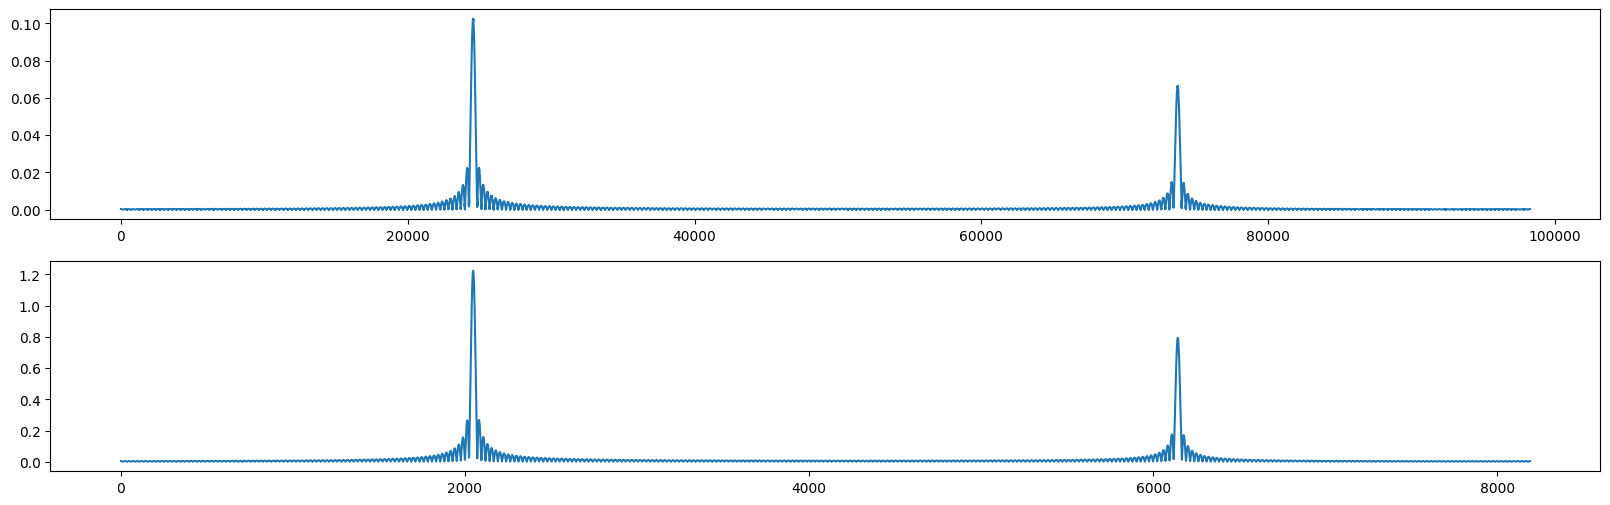

In [27]:
# target = (fftshift(fft(hr_object))[len(hr_object)//2 - A_samples//2 - offset//2:len(hr_object)//2 + A_samples//2] - offset//2)

plt.figure(figsize=(20,3))
_, axs = plt.subplots(2,1, figsize=(20,6))
axs[0].plot(np.abs(hr_object))
# axs[0].set_xlim(47000, 50000)
axs[1].plot(np.abs(image_amp))
